# Natural Language Processing - Condition Prediction based on the Review

The objective of this work is to predict the condition that the patient is treating based on its medical review using Machine Learning.

The dataset used in this project provides several entries for several drugs being used to treat different conditions. 
For each entry, there is a personal review of the medicine used.

The data was retrieved from:
https://archive.ics.uci.edu/ml/datasets/Drug+Review+Dataset+%28Drugs.com%29

## Upload the Data

In [1]:
# Let's import the libraries used in this study
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
# Let's import more libraries
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import SGDClassifier
from sklearn.model_selection import GridSearchCV

In [3]:
# Lets upload the test then train and concatenate the data to one dataframe
# We will split the dataset again later
df = pd.read_csv("drugsComTrain_raw.tsv",sep='\t', index_col=0)
df_t = pd.read_csv("drugsComTest_raw.tsv",sep='\t', index_col=0)

df = pd.concat([df,  df_t])

In [5]:
df.head()

,drugName,condition,review,rating,date,usefulCount
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0,"May 20, 2012",27
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0,"April 27, 2010",192
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0,"December 14, 2009",17
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0,"November 3, 2015",10
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0,"November 27, 2016",37


In [6]:
# Let's drop the columns that we are not going to use
df.drop(['date', 'usefulCount'], axis=1, inplace = True)

In [7]:
df.head()

,drugName,condition,review,rating
206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9.0
95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8.0
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0
35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9.0


# Exploratory Data Analysis

In [8]:
df['condition'].value_counts()

Birth Control                                   38436
Depression                                      12164
Pain                                             8245
Anxiety                                          7812
Acne                                             7435
                                                ...  
Ramsay Hunt Syndrome                                1
Bartonellosis                                       1
145</span> users found this comment helpful.        1
Parkinsonian Trem                                   1
Esophageal Spasm                                    1
Name: condition, Length: 916, dtype: int64

There are more than 900 conditions in our dataset. Let's only consider the 8 more common conditions to be predicted.

In [9]:
# 8 more common conditions considered in this work
df['condition'].value_counts().head(8)

Birth Control      38436
Depression         12164
Pain                8245
Anxiety             7812
Acne                7435
Bipolar Disorde     5604
Insomnia            4904
Weight Loss         4857
Name: condition, dtype: int64

In [10]:
list_conditions = list(df['condition'].value_counts().head(8).index)

In [11]:
# Dataframes with only the 8 most common conditions
df = df[df['condition'].isin(list_conditions)]

In [12]:
df.head(8)

,drugName,condition,review,rating
92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5.0
138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8.0
102654,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10.0
48928,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8.0
75612,L-methylfolate,Depression,"""I have taken anti-depressants for years, with...",10.0
98494,Nexplanon,Birth Control,"""Started Nexplanon 2 months ago because I have...",3.0
212077,Lamotrigine,Bipolar Disorde,"""I&#039;ve been on every medicine under the su...",10.0
231466,Trazodone,Insomnia,"""I have insomnia, it&#039;s horrible. My story...",10.0


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 89457 entries, 92703 to 47656
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   drugName   89457 non-null  object 
 1   condition  89457 non-null  object 
 2   review     89457 non-null  object 
 3   rating     89457 non-null  float64
dtypes: float64(1), object(3)
memory usage: 3.4+ MB


In [14]:
df.describe()

,rating
count,89457.000000
mean,6.812424
std,3.246492
min,1.000000
25%,4.000000
50%,8.000000
75%,10.000000
max,10.000000


In our train data, there are 89457 entries with no missing values. The mean rating is 6.81.

In [15]:
# Drug Name analysis
df['drugName'].value_counts()

Etonogestrel                         4394
Ethinyl estradiol / norethindrone    3250
Levonorgestrel                       2884
Nexplanon                            2883
Ethinyl estradiol / norgestimate     2367
                                     ... 
Doans Pills Extra Strength              1
Unisom SleepMelts                       1
BenzEFoam Ultra                         1
Tylenol Arthritis Pain                  1
Advil PM                                1
Name: drugName, Length: 763, dtype: int64

There are 763 medicines that treat the 8 most common conditions. 

The three most common medicinal drugs are: Levonorgestrel, Etonogestrel and Ethinyl estradiol / norethindrone.

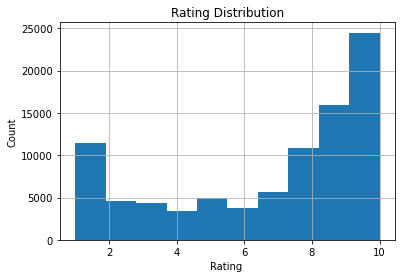

In [16]:
# Let's analyse the rating distribution from our data
df['rating'].hist()
plt.xlabel('Rating ')
plt.ylabel("Count")
plt.title('Rating Distribution')
plt.show()

## Extracting features from text files

In order to perform machine learning on text documents, we will first delete the stopwords and all of the punctuations in the reviews column.

In [17]:
# Let's import some libraries used in this section
import nltk
from nltk.corpus import stopwords
import string

In [18]:
def remove_punctuation(df):
    '''Function that removes all of the punctuations in the reviews'''
    no_punctuation = ''
    try:
        for char in df:
            if char not in string.punctuation:
                no_punctuation = no_punctuation + char
    except:
        pass
    df = no_punctuation
    return df

In [19]:
def remove_stopwords(df):
    '''Function that removes all of the stopwords in the reviews'''
    no_stopword = ''
    try:
        for word in df.lower().split():
            if word not in stopwords.words('english'):
                no_stopword = no_stopword + ' ' + word
    except:
        pass
    df = no_stopword
    return df

In [20]:
# Let's remove all of the punctuations in the reviews
df['review'] = df['review'].apply(remove_punctuation)

In [21]:
# Let's remove all of the stopwords in the reviews
df['review'] = df['review'].apply(remove_stopwords)

In [22]:
df.head()

,drugName,condition,review,rating
92703,Lybrel,Birth Control,used take another oral contraceptive 21 pill ...,5.0
138000,Ortho Evra,Birth Control,first time using form birth control i039m gla...,8.0
102654,Aripiprazole,Bipolar Disorde,abilify changed life hope zoloft clonidine fi...,10.0
48928,Ethinyl estradiol / levonorgestrel,Birth Control,pill many years doctor changed rx chateal eff...,8.0
75612,L-methylfolate,Depression,taken antidepressants years improvement mostl...,10.0


## Using the Pipeline

### Train Test Split

In [23]:
from sklearn.model_selection import train_test_split

In [24]:
X = df['review']
y = df['condition']

In [25]:
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.3)

### Building a Pipeline

In [86]:
pipeline = Pipeline([
    ('vect', CountVectorizer((1,2))),  # strings to token integer counts
    ('tfidf', TfidfTransformer(use_idf=True)),  # integer counts to weighted TF-IDF scores
    ('clf', SGDClassifier(penalty='l2', alpha=1e-5,
                          random_state=42, max_iter=100, 
                          tol=None)),  # train on TF-IDF vectors w/ Support Vector Machine classifier
])

In [82]:
# Let's fit the pipeline
pipeline.fit(X_train,y_train)

Pipeline(steps=[('vect', CountVectorizer(input=(1, 2))),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(alpha=1e-05, max_iter=100, tol=None))])

In [83]:
# Let's save the predictions
predictions = pipeline.predict(X_test)

In [84]:
# Let's print the classification report
print(classification_report(y_test,predictions))

                 precision    recall  f1-score   support

           Acne       0.94      0.91      0.93      2193
        Anxiety       0.85      0.77      0.81      2339
Bipolar Disorde       0.87      0.81      0.84      1662
  Birth Control       0.97      0.99      0.98     11582
     Depression       0.82      0.85      0.83      3658
       Insomnia       0.87      0.89      0.88      1496
           Pain       0.93      0.95      0.94      2434
    Weight Loss       0.96      0.96      0.96      1474

       accuracy                           0.92     26838
      macro avg       0.90      0.89      0.90     26838
   weighted avg       0.92      0.92      0.92     26838



We achieved 92% accuracy using the SVM for this natural language processing project in machine learning.

### Gridsearch Method

Let's use the gridsearch method to tune better the parameters of the Pipeline.

In [65]:
parameters = {
    'vect__ngram_range': [(1, 1), (1, 2)],
    'tfidf__use_idf': (True, False),
    'clf__alpha': (1e-4, 1e-5, 1e-6),
}

In [66]:
grid = GridSearchCV(pipeline, parameters, cv=5, n_jobs=-1)

In [67]:
grid.fit(X_train,y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('vect', CountVectorizer(input=(1, 2))),
                                       ('tfidf', TfidfTransformer()),
                                       ('clf',
                                        SGDClassifier(alpha=1e-05, max_iter=100,
                                                      random_state=42,
                                                      tol=None))]),
             n_jobs=-1,
             param_grid={'clf__alpha': (0.0001, 1e-05, 1e-06),
                         'tfidf__use_idf': (True, False),
                         'vect__ngram_range': [(1, 1), (1, 2), (2, 1)]})

In [68]:
grid.best_params_

{'clf__alpha': 1e-05, 'tfidf__use_idf': True, 'vect__ngram_range': (1, 2)}

In [69]:
grid.best_score_

0.9369361103770915

The gridsearch method shows up that we have picked relatively the right parameters for the pipeline and prediction.